# Using Effective Quadratures for supervised machine learning
blah blah blah, boston housing dataset

First things first, we need to import the necessary libraries...

In [23]:
# Check if running on colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# pip install any missing packages
if IN_COLAB:
  !pip install git+https://github.com/Effective-Quadratures/Effective-Quadratures.git@feature_robust # for specific branch

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

from equadratures import *

## Load Boston housing data-set 

In [200]:
boston = datasets.load_boston()
boston_df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

## Add some random noise features

In [190]:
N = boston_df.shape[0]
noise = np.random.rand(N, 3)
noise_df = pd.DataFrame(data=noise, columns=['noise1', 'noise2', 'noise3'])
Xorig = pd.concat([boston_df, noise_df], axis=1)
y = boston['target']

## Scale data

In [191]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(Xorig)

## Create helper classes and functions

### EQmodel class to interface with sklearn

In [27]:
class EQmodel(object):
    def __init__(self,method,order=1,lamda=None,alpha=None,verbose=False):
        self.method = method
        self.order = order
        self.lamda = lamda
        self.alpha = alpha
        
    def fit(self,X,y):
        s = Parameter(distribution='uniform', lower=-1, upper=1, order=self.order,endpoints='both')
        self.param = [s for _ in range(X.shape[1])]
        self.basis = Basis('total-order') #Don't put tensor-grid, it will take forever!
        
        solver_args = {}
        if self.lamda is not None: solver_args["param1"] = self.lamda
        if self.alpha is not None: solver_args["param2"] =self.alpha
        self.poly = Poly(parameters=self.param, basis=self.basis, method=self.method, \
              sampling_args= {'mesh': 'user-defined', 'sample-points':X, 'sample-outputs': y.reshape(-1,1)},
               solver_args=solver_args)
        self.poly.set_model()
  
    def predict(self,X):
        return self.poly.get_polyfit(X)
        
    def score(self,X,y):
        ypred = self.poly.get_polyfit(X)
        #r2 = r2_score(ypred,y)
        MAE = mean_absolute_error(ypred,y) 
        return -MAE
        
    # For sklearn gridsearch compatibility
    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return {"method": self.method,"order": self.order, 
                "alpha": self.alpha, "lamda": self.lamda}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

### Gridsearch helper functions

In [174]:
def myGridSearch(model,parameters,X,y,kfold=5):
    cv = KFold(n_splits=kfold,shuffle=True,random_state=42)
    gs = GridSearchCV(model, parameters,return_train_score=True,cv=cv,verbose=2,n_jobs=-1,scoring='neg_mean_absolute_error')
    gs.fit(X, y)

    print("Best score = %.3f with parameters:" %gs.best_score_)
    print(gs.best_params_)
   
    # Parse full results into df
    results = pd.DataFrame(gs.cv_results_)
    results = results.loc[:,~results.columns.str.contains('_time|split|rank|params')] 
    return results

def plot_GS(results,ranges,params,param_names,x_axis,sub_axis,index,scale='log'):
    df_order = ['param_' + key for key in params.keys()]
    results = results.sort_values(df_order)
    shape = [len(ranges[0]),len(ranges[1]),len(ranges[2])]
    mean_train_score = results['mean_train_score'].to_numpy().reshape(shape)
    mean_test_score = results['mean_test_score'].to_numpy().reshape(shape)

    # Rearrange scoring arrays. axis=0 will be xaxis of plots, take first indices of 
    # axis=1 for the two subplots, index axis=2 by "index"
    nplots = np.minimum(shape[sub_axis],2)
    remain_axis = list({0,1,2} - {x_axis,sub_axis})[0]
    reorder = [x_axis, sub_axis, remain_axis]
    plot_train = mean_train_score.transpose(reorder)[:,:nplots,index]
    plot_test  = mean_test_score.transpose(reorder)[:,:nplots,index]
    param_names = [param_names[i] for i in reorder]
    ranges = [ranges[i] for i in reorder]

    if nplots==1:
        fig, ax1 = plt.subplots(1, 1,figsize=(4,5),constrained_layout=True)
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(9,5),constrained_layout=True)
    fig.suptitle('$-MAE$ vs %s, with %s = %.3f' %(param_names[0],param_names[2],ranges[2][index]))
    # subplot1
    ax1.set_title('%s = %.3f' %(param_names[1],ranges[1][0]))
    ax1.plot(ranges[0],plot_train[:,0],label='Train')
    ax1.plot(ranges[0],plot_test[:,0],label='Test')
    ax1.set_xscale(scale)
    ax1.set_xlabel(param_names[0])
    ax1.set_ylabel('$-MAE$')
    #ax1.set_ylim([0.5,1.05*np.max(plot_train[:,0])])
    ax1.legend()
    if nplots==2:
        # subplot2
        ax2.set_title('%s = %.3f' %(param_names[1],ranges[1][1]))
        ax2.plot(ranges[0],plot_train[:,1],label='Train')
        ax2.plot(ranges[0],plot_test[:,1],label='Test')
        ax2.set_xscale(scale)
        ax2.set_xlabel(param_names[0])
        ax2.set_ylabel('$-MAE$')
        #ax2.set_ylim([0.5,1.05*np.max(plot_train[:,1])])
        ax2.legend()

    plt.show()

## Ordinary least squares regression

In [196]:
params = {'order':[1,2,3]}
linear = EQmodel('least-squares')
results = myGridSearch(linear,params,X,y,kfold=5)
display(results)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s


Best score = -2.703 with parameters:
{'order': 2}


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.3s finished


,param_order,mean_test_score,std_test_score,mean_train_score,std_train_score
0,1,-3.365873,0.188893,-3.220667e+00,5.642332e-02
1,2,-2.702612,0.298558,-1.540049e+00,3.600649e-02
2,3,-6.107653,0.574954,-5.408881e-14,1.018895e-14


Bias-variance trade-off, over-fitting (small training error but large test error) for 3rd order.  

Best accuracy (smallest MAE) is with second order linear regression.

For comparision, scikit-learn...

In [32]:
cv = KFold(n_splits=5,shuffle=True,random_state=42)
print('mean_test_score for sklearn OLS (order=1) = %.4f'
      %np.mean(cross_val_score(LinearRegression(), X, y, cv=cv,scoring=score)))

model = make_pipeline(PolynomialFeatures(2), LinearRegression())
print('mean_test_score for sklearn OLS (order=2) = %.4f'
      %np.mean(cross_val_score(model, X, y, cv=cv,scoring=score)))

model = make_pipeline(PolynomialFeatures(3), LinearRegression())
print('mean_test_score for sklearn OLS (order=3) = %.4f'
      %np.mean(cross_val_score(model, X, y, cv=cv,scoring=score)))

mean_test_score for sklearn OLS (order=1) = -3.4218
mean_test_score for sklearn OLS (order=2) = -2.9886
mean_test_score for sklearn OLS (order=3) = -6.3371


Same findings here...

## Elastic net regression

### Effective Quadratures

In [176]:
lamda_range = np.logspace(-5, 0, 20)
alpha_range = [0,0.5,1]
order_range = [1,2]
params = {'lamda':lamda_range,'alpha':alpha_range,'order':order_range}
elasticnet = EQmodel('elastic-net')
results_eq = myGridSearch(elasticnet,params,X,y,kfold=5)
#display(results_eq)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    8.1s


Best score = -2.433 with parameters:
{'alpha': 0.5, 'lamda': 0.04832930238571752, 'order': 2}


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   14.5s finished


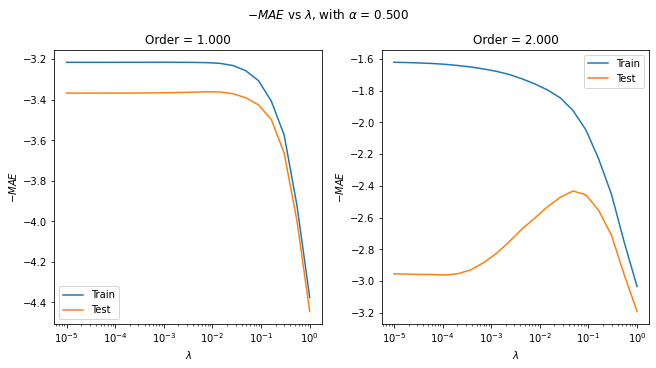

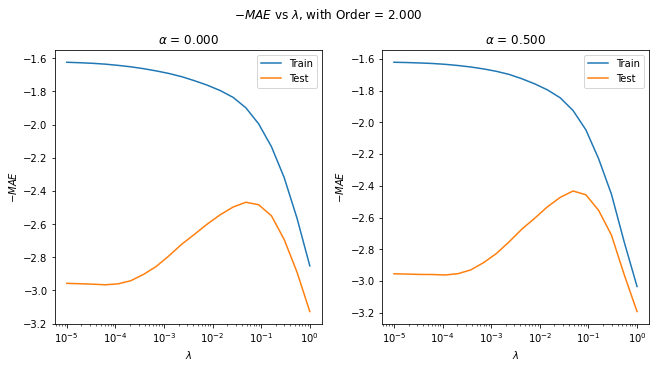

In [177]:
ranges = [lamda_range,alpha_range,order_range]
param_names = ['$\lambda$','$\\alpha$','Order']
plot_GS(results_eq,ranges,params,param_names,0,2,1,scale='log')
plot_GS(results_eq,ranges,params,param_names,0,1,1,scale='log')
#x_axis,sub_axis,index

Best parameters are $\alpha=0.5$, $\lambda=0.048$ and polynomial order = 2.

### Scikit-learn

In [178]:
params = {'alpha':lamda_range,'l1_ratio':alpha_range}
poly = PolynomialFeatures(2)
Xpoly = poly.fit_transform(X)
results_sk = myGridSearch(ElasticNet(),params,Xpoly,y,kfold=5)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s


Best score = -2.456 with parameters:
{'alpha': 0.01438449888287663, 'l1_ratio': 0.5}


[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:    2.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.1s finished


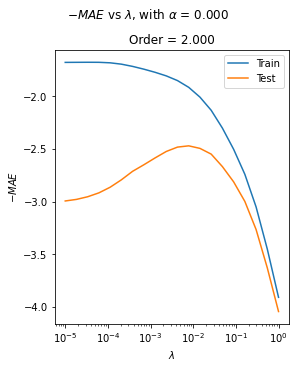

In [180]:
ranges = [lamda_range,alpha_range,[2]]
param_names = ['$\lambda$','$\\alpha$','Order']
plot_GS(results_sk,ranges,params,param_names,0,2,0,scale='log')

Best parameters are $\alpha=0.5$, $\lambda=0.014$ and polynomial order = 2.

## What is the "correct" polynomial order

In [181]:
lamda_range = [1e-6,0.1]
alpha_range = [1.0]
order_range = [1,2,3,4]
params = {'lamda':lamda_range,'alpha':alpha_range,'order':order_range}
elasticnet = EQmodel('elastic-net')
results_eq = myGridSearch(elasticnet,params,X,y,kfold=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  40 | elapsed:    7.2s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   39.5s finished


Best score = -2.416 with parameters:
{'alpha': 1.0, 'lamda': 0.1, 'order': 3}


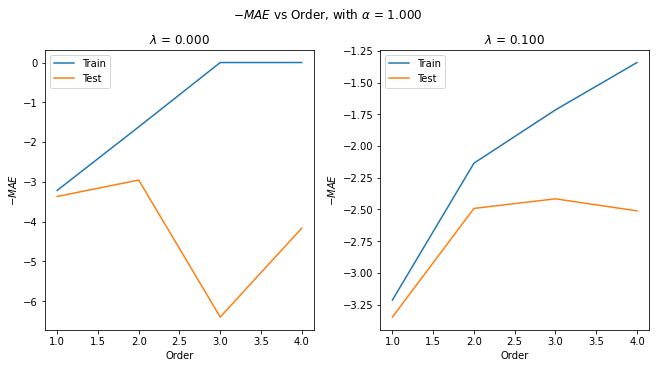

In [182]:
ranges = [lamda_range,alpha_range,order_range]
param_names = ['$\lambda$','$\\alpha$','Order']
plot_GS(results_eq,ranges,params,param_names,2,0,0,scale='linear')

## Aiding intpretationof the model coefficients

Just do this for 1st order to keep simple, but could extend to look at higher order terms too...

In [183]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42,shuffle=True)

MAE = -3.221


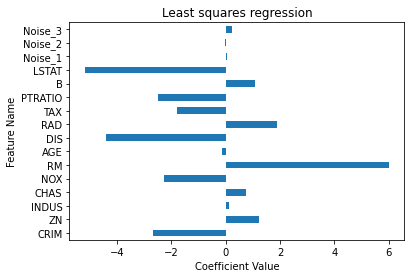

In [188]:
ltsq = EQmodel('least-squares',order=1)
ltsq.fit(X,y)
print('MAE = %.3f' %(ltsq.score(X,y)))

coeffs = ltsq.poly.get_coefficients().squeeze()
pd.Series(coeffs[:0:-1], 
              index=Xorig.columns).plot(kind='barh')
plt.title('Least squares regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.show()

MAE = -3.412


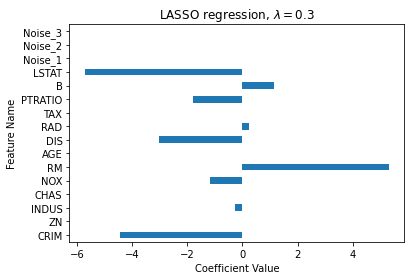

In [187]:
elasticnet = EQmodel('elastic-net',order=1,lamda=0.3,alpha=1)
elasticnet.fit(X,y)
print('MAE = %.3f' %(elasticnet.score(X,y)))

coeffs = elasticnet.poly.get_coefficients().squeeze()
pd.Series(coeffs[:0:-1], 
             index=Xorig.columns).plot(kind='barh')
plt.title('LASSO regression, $\lambda=0.3$')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.show()

## Comparision to Random-forests

### Accuracy

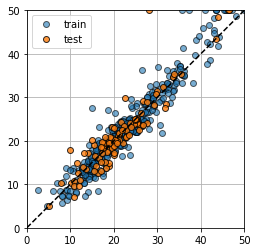

Training MAE = 1.94
Test MAE = 2.12


In [97]:
elasticnet = EQmodel('elastic-net',order=3,lamda=0.1624,alpha=1)
elasticnet.fit(X_train,y_train)
ypred_train = elasticnet.predict(X_train)
ypred_test = elasticnet.predict(X_test)

fig, ax = plt.subplots()
ax.plot(ypred_train,y_train,'o',alpha=0.6,mec='k',label='train')
ax.plot(ypred_test,y_test,'o',alpha=0.8,mec='k',label='test')
ax.plot([0,50],[0,50],'k--')
ax.set_aspect(1)
ax.set_xlim([0,50])
ax.set_ylim([0,50])
ax.grid('on')
plt.legend()
plt.show()

print('Training MAE = %.2f' %(abs(elasticnet.score(X_train,y_train))))
print('Test MAE = %.2f' %(abs(elasticnet.score(X_test,y_test))))

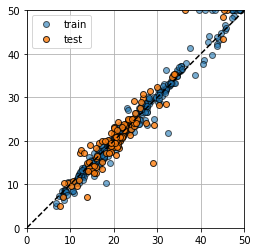

Training MAE = 0.96
Test MAE = 2.11


In [81]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100,max_depth=None,criterion='mae')
rf.fit(X_train,y_train)
ypred_train = rf.predict(X_train)
ypred_test = rf.predict(X_test)

fig, ax = plt.subplots()
ax.plot(ypred_train,y_train,'o',alpha=0.6,mec='k',label='train')
ax.plot(ypred_test,y_test,'o',alpha=0.8,mec='k',label='test')
ax.plot([0,50],[0,50],'k--')
ax.set_aspect(1)
ax.set_xlim([0,50])
ax.set_ylim([0,50])
ax.grid('on')
plt.legend()
plt.show()

print('Training MAE = %.2f' %(abs(mean_absolute_error(ypred_train,y_train))))
print('Test MAE = %.2f' %(abs(mean_absolute_error(ypred_test,y_test))))

## Conclusions

Elastic neet (LASSO and Ridge) regularisation extends the capability of polys for "high" dimensional applications

LASSO provides a degree of feature selection:
- Not much of a gain in accuracy over OLS for 1st order
- But allows for better model intepretation
- Regularises high order terms, allowing for signficantly improved accuracy as we increase the order. 

3rd order poly with LASSO regularisation competitive with Random forest.

## Still to come!

Polynomials vs Random forests, part 2:
- How much data do we need?
- Estimating model confidence
- Model intpretation - Sobol' indices and coeffcients versus SHAP values